In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import scipy
from tools import pca_reduce, plot

In [2]:
%matplotlib inline

In [3]:
plt.rcParams['figure.figsize'] = [10., 10.]
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14 
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 14

In [4]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

# Classification

We explore different classification algorithms on a binary problem using the MNIST data

In [5]:
fname = 'mnist.npz'
#fname = 'galaxy.npz'

X = pca_reduce(np.load(fname)['X'], 2, whiten=True)
y = np.load(fname)['y']

In [6]:
X_orig = np.load(fname)['X']

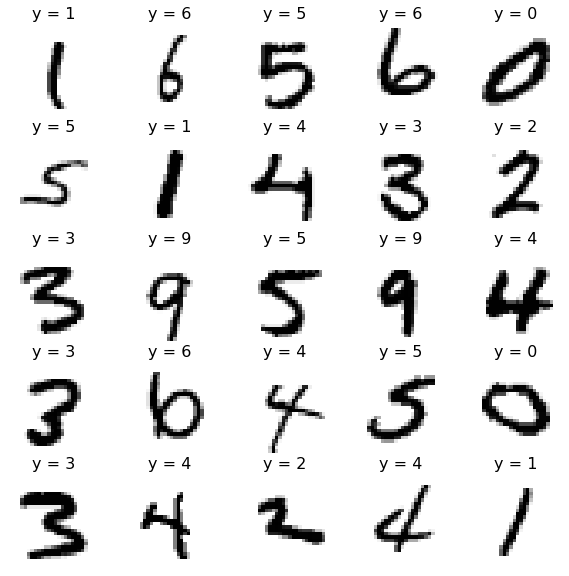

In [7]:
plot(X_orig, y)

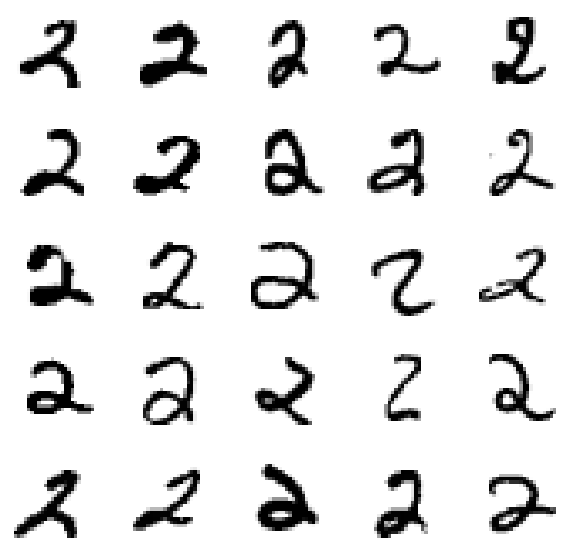

In [9]:
mask = y == 2
plot(X_orig[mask])

We'll start with our standard PCE to 2d

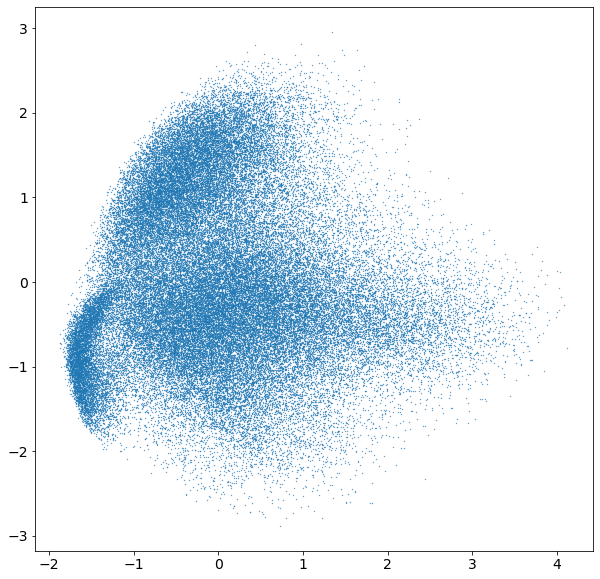

In [8]:
plt_data = plt.scatter(X[:, 0], X[:, 1], s=0.1, cmap=plt.cm.get_cmap('Spectral', 10))

The large difference to, for example clustering, is that now we have the truth lables! Let's plot them:

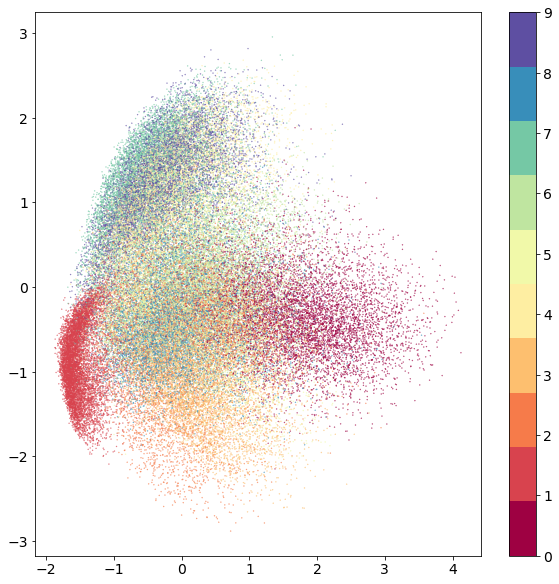

In [9]:
plt_data = plt.scatter(X[:, 0], X[:, 1], s=0.1, c=y ,cmap=plt.cm.get_cmap('Spectral', 10))
plt.colorbar()

## Binary classification

To reduce the problem, we start with binary classification, trying to distinguish the digits (1, 4, 5, 7, 9) from the rest.

In [10]:
# do binary classification first (digits)
y = ((y == 1) | (y == 9) | (y == 5) | (y == 7) | (y == 4)).astype(np.float32)

# galaxy
# y = ((y == 0) | (y == 3)).astype(np.float32)

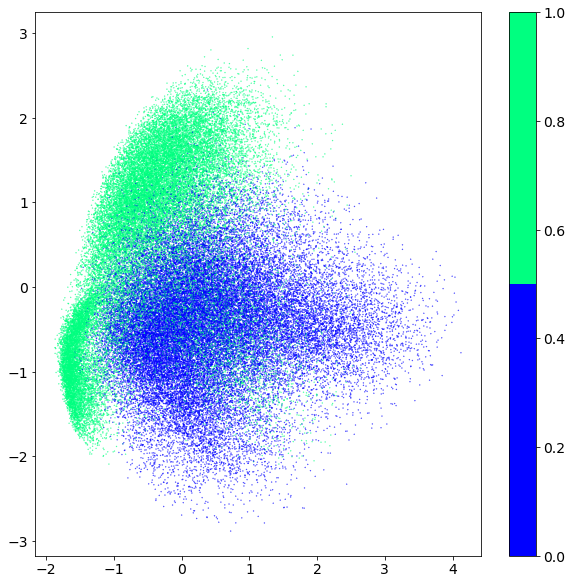

In [11]:
plt_data = plt.scatter(X[:, 0], X[:, 1], s=0.1, c=y ,cmap=plt.cm.get_cmap("winter", 2))
plt.colorbar()

# Decision Trees

let's suppose we can introduce a cut on a variable to separate the data intwo the two desired calsses.

What would we call a "good" cut?

In [13]:
# the true probability:
p = y

In [17]:
# the estimated probability given a cut on PC2
def get_q(cut):
    q = np.zeros(len(X))
    mask = X[:, 1] > cut
    q[mask] = np.average(y[mask])
    q[~mask] = np.average(y[~mask])
    return q

In [15]:
q = get_q(0)

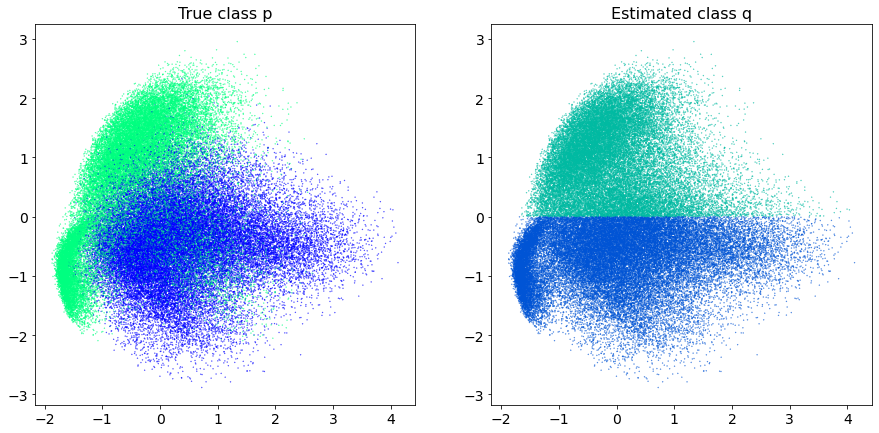

In [18]:
fig, ax = plt.subplots(1,2, figsize=(15,7))

ax[0].set_title("True class p")
plt_data = ax[0].scatter(X[:, 0], X[:, 1], s=0.1, c=p ,cmap=plt.cm.get_cmap("winter", 2))
ax[1].set_title("Estimated class q")
plt_data = ax[1].scatter(X[:, 0], X[:, 1], s=0.1, c=q ,cmap="winter", vmin=0, vmax=1)

Let's compute the binary cross entropy (BCE), aka log loss:

In [19]:
-np.average((p * np.log(q) + (1-p) * np.log(1-q)))

0.6126189119589449

In [20]:
# to avoid nummerical instability it is customary to add small epsilon values inside the log
eps = 1e-15
-np.average((p * np.log(q + eps) + (1-p) * np.log(1-q + eps)))

0.6126189119589431

We can then define a loss function for our chosen cut value

In [21]:
def loss(cut):
    q = get_q(cut)
    eps = 1e-15
    return -np.average((p * np.log(q + eps) + (1-p) * np.log(1-q + eps)))

And see how this behaves for different values:

In [22]:
cuts = np.linspace(-3, 3, 100)
losses = []
for cut in cuts:
    losses.append(loss(cut))

/home/peller/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/peller/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'loss')

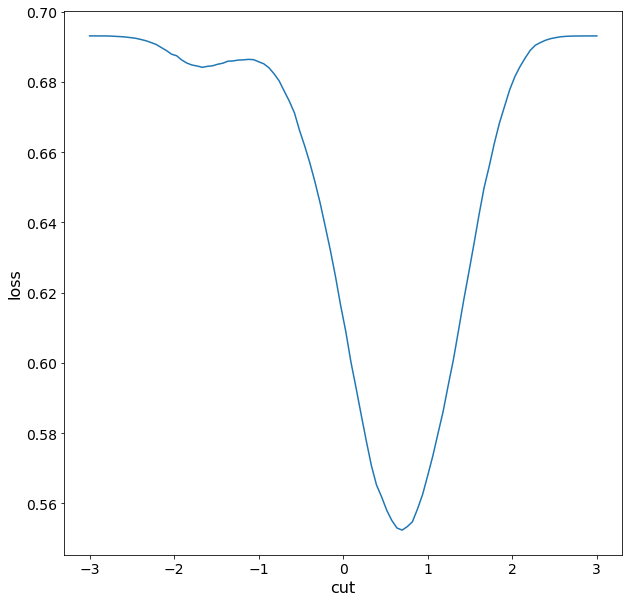

In [23]:
plt.plot(cuts, losses)
plt.gca().set_xlabel('cut')
plt.gca().set_ylabel('loss')

Let's find the best value by using an optimizer!

In [24]:
from scipy import optimize

In [25]:
res = optimize.minimize(loss, 0, options={'eps':1e-4})

In [27]:
print(res.x)

[0.62451373]


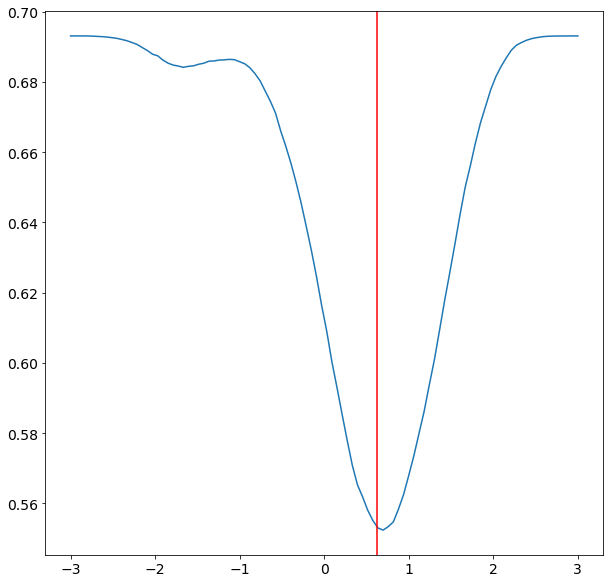

In [28]:
plt.plot(cuts, losses)
plt.axvline(res.x, c='r')

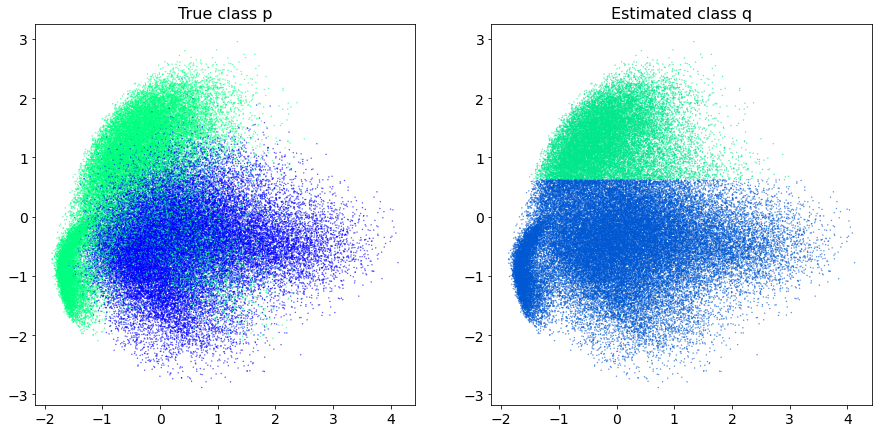

In [29]:
fig, ax = plt.subplots(1,2, figsize=(15,7))

q = get_q(res.x)

ax[0].set_title("True class p")
plt_data = ax[0].scatter(X[:, 0], X[:, 1], s=0.1, c=p ,cmap=plt.cm.get_cmap("winter", 2))
ax[1].set_title("Estimated class q")
plt_data = ax[1].scatter(X[:, 0], X[:, 1], s=0.1, c=q ,cmap="winter", vmin=0, vmax=1)

We can perform this operation automatically via sklearn, and let it iteratively grow a decision tree:

In [35]:
from sklearn.tree import DecisionTreeClassifier

In [38]:
# max_depth = 1 is equivalent to our example above
clf = DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [39]:
clf.fit(X, y)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

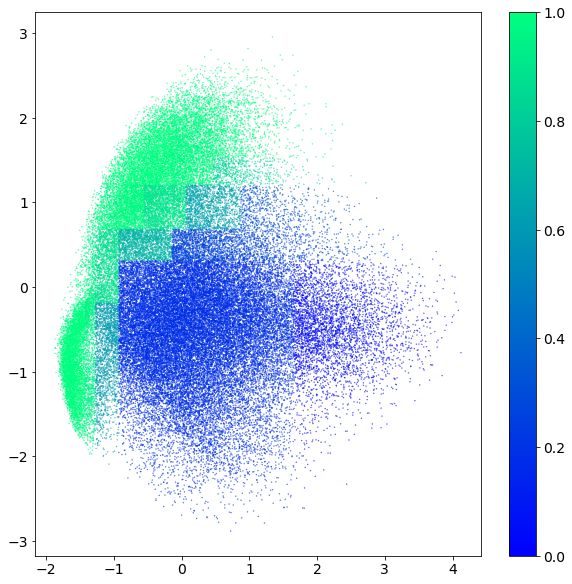

In [40]:
q = clf.predict_proba(X)
plt_data = plt.scatter(X[:, 0], X[:, 1], s=0.1, c=q[:, 1] ,cmap=plt.cm.get_cmap("winter"), vmin=0, vmax=1)
plt.colorbar()

To get predicted lables, we can do thresholding on the output. By default, if q > 0.5, then y=1, else 0

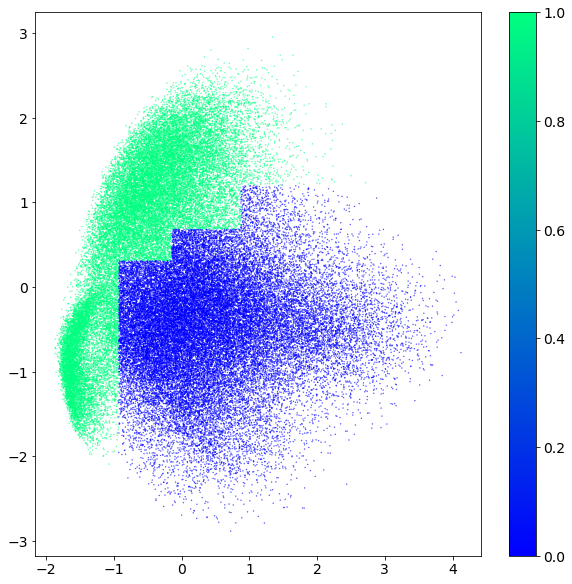

In [41]:
y_pred = clf.predict(X)
plt_data = plt.scatter(X[:, 0], X[:, 1], s=0.1, c=y_pred ,cmap=plt.cm.get_cmap("winter"), vmin=0, vmax=1)
plt.colorbar()

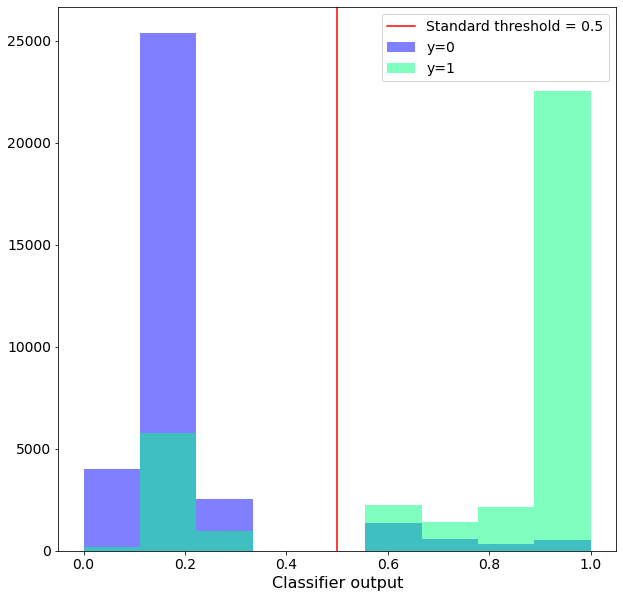

In [42]:
bins = np.linspace(0, 1, 10)
plt.hist(q[:,1][y==0], bins=bins, color=plt.cm.winter(0), label='y=0', alpha=0.5)
plt.hist(q[:,1][y==1], bins=bins, color=plt.cm.winter(1000), label='y=1', alpha=0.5)
plt.axvline(0.5, color='red', label = 'Standard threshold = 0.5')
plt.gca().set_xlabel("Classifier output")
plt.legend()

# Diagnostics: FPR & TPR and ROC curves

Calculate the false positiove and the true positive rates for a chose threshold value:

In [46]:
def fpr_and_tpr(y, q, threshold=0.5):
    z = q[:, 0] > threshold
    y = y.astype(bool)
    TP = np.sum(y & z)
    TN = np.sum(~y & ~z)
    FP = np.sum(~y & z)
    FN = np.sum(y & ~z)
    
    return TP/(TP+FN), FP/(TN+FP)

In [47]:
fpr_and_tpr(y, q)

(0.19614348504182616, 0.9192745069814309)

We can do this for many different threshold values:

In [48]:
tprs = []
fprs = []

for threshold in np.linspace(0, 1, 100):
    t,f = fpr_and_tpr(y, q, threshold)
    tprs.append(t)
    fprs.append(f)

And plot the resulting curve, known as the ROC curve

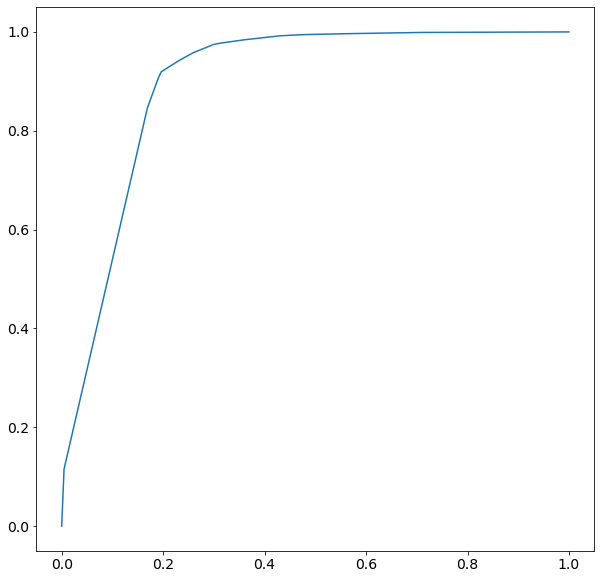

In [50]:
plt.plot(tprs, fprs)

(same functionality is readily available in sklearn too)

## Train-Test splitting

We always need split data into independent training and testing samples for supervised learning!

In [51]:
X_train = X[:60000]
X_test = X[60000:]
y_train = y[:60000]
y_test = y[60000:]

In [52]:
# galaxy
# X_train = X[:8000]
# X_test = X[8000:]
# y_train = y[:8000]
# y_test = y[8000:]

In [304]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=30, max_depth=10, criterion="entropy")

#clf = DecisionTreeClassifier(max_depth=20, criterion="entropy")

clf.fit(X_train, y_train, )
y_predicted = clf.predict_proba(X_train)
y_test_predicted = clf.predict_proba(X_test)
y_predicted_label = clf.predict(X_train)
y_test_predicted_label = clf.predict(X_test)

In [305]:
def plot_clf(y_predicted, y_test_predicted, nbins=100):
    fig, ax = plt.subplots(1, 2, figsize=(15,7))

    bins = np.linspace(0, 1, nbins)
    ax[0].hist(y_predicted[y_train==0][:,1], bins=bins, color=plt.cm.winter(0), label='Train (y=0)', alpha=0.5, density=True, hatch="\\\\\\\\", edgecolor='w', linewidth=0)
    ax[0].hist(y_predicted[y_train==1][:,1], bins=bins, color=plt.cm.winter(1000), label='Train (y=1)', alpha=0.5, density=True, hatch='////', edgecolor='k', linewidth=0)
    ax[0].hist(y_test_predicted[y_test==0][:,1], bins=bins, color=plt.cm.winter(0), histtype='step', lw=2, label='Test (y=0)', density=True)
    ax[0].hist(y_test_predicted[y_test==1][:,1], bins=bins, color='green', histtype='step', lw=2, label='Test (y=0)', density=True)
    ax[0].axvline(0.5, color='red', label = 'Standard threshold = 0.5')
    ax[0].set_xlabel("Classifier output")
    ax[0].legend()

    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_predicted[:,1])
    fpr_train, tpr_train, _ = roc_curve(y_train, y_predicted[:,1])
    bl = plt.plot(fpr_test, tpr_test, ls='-', label='Test (AUC = %0.2f)' %(auc(fpr_test, tpr_test)))
    ax[1].plot(fpr_train, tpr_train, ls='--', c=bl[0].get_color(), label='Train (AUC = %0.2f)' %(auc(fpr_train, tpr_train)))
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_ylim([0.0, 1.0])
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_ylabel('True Positive Rate')
    ax[1].set_title('Receiver operating characteristic')
    ax[1].legend(loc="lower right")

Plot the classifier outputs and the ROC curves for training and testing sets separately:

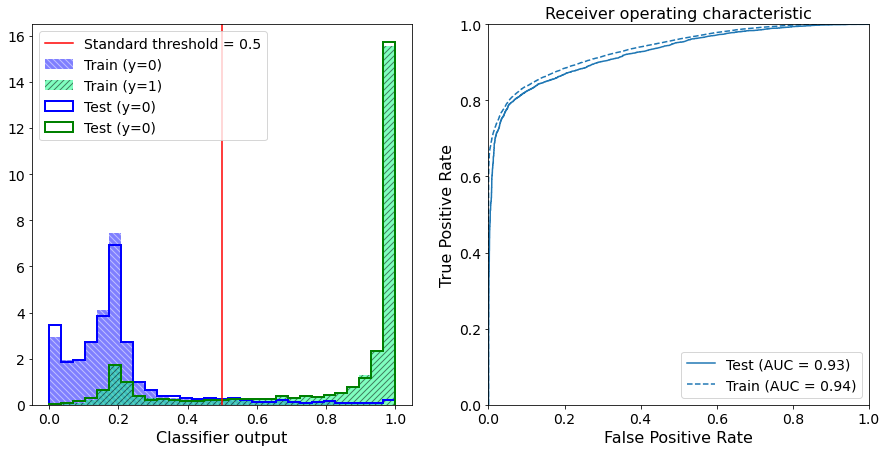

In [306]:
plot_clf(y_predicted, y_test_predicted, 30)

# Logistic Regression

Let us see how we can do the classification task using a linear model instead of a DT.

This is the logictic function:

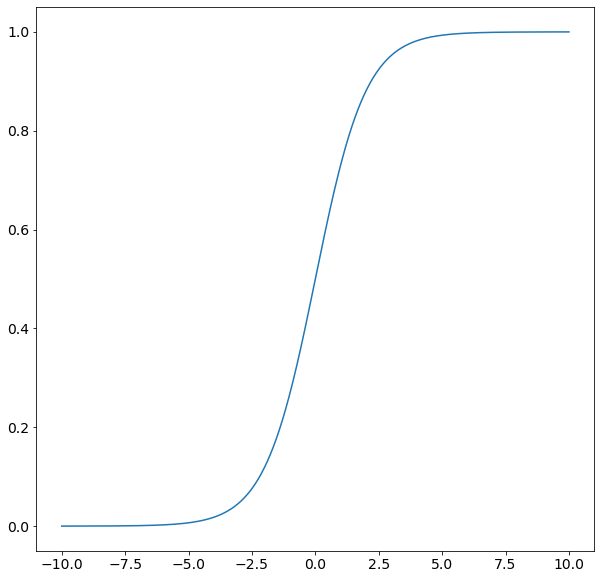

In [307]:
x = np.linspace(-10, 10, 1000)
plt.plot(x, 1/(1+np.exp(-x)))

we can start by using a random guess for our paameters of `A` and `b` (here a 3d array for the two components of `A` first and then `b`):

In [363]:
params = np.random.randn(X.shape[1] + 1)

In [364]:
params

array([ 1.35202145,  0.24920813, -0.52229979])

This will be the output, astimated class probability:

In [365]:
q = 1 / (1 + np.exp(-(X_train @ params[:-1] + params[-1])))

We can immediately calculate the loss:

In [366]:
-np.average((y_train * np.log(q) + (1-y_train) * np.log(1-q)))

1.1773243701470464

We just rewrite the same inside a loss function that we can then use for optimization

In [400]:
from scipy.special import expit
def loss(params):
    eps = 1e-7
    q = expit(X_train @ params[:-1] + params[-1])
    return - np.average((y_train * np.log(q+eps) + (1-y_train) * np.log(1-q+eps)))

In [401]:
loss(params)

0.7937425050541526

Optimize:

In [402]:
res = optimize.minimize(loss, params)
params = res.x

In [403]:
res.x

array([-1.6473952 ,  1.50380183, -0.14948572])

In [404]:
q = expit(X_train @ params[:-1] + params[-1])
q_test = expit(X_test @ params[:-1] + params[-1])

In [405]:
y_predicted = np.stack((1-q, q)).T
y_test_predicted = np.stack((1-q_test, q_test)).T

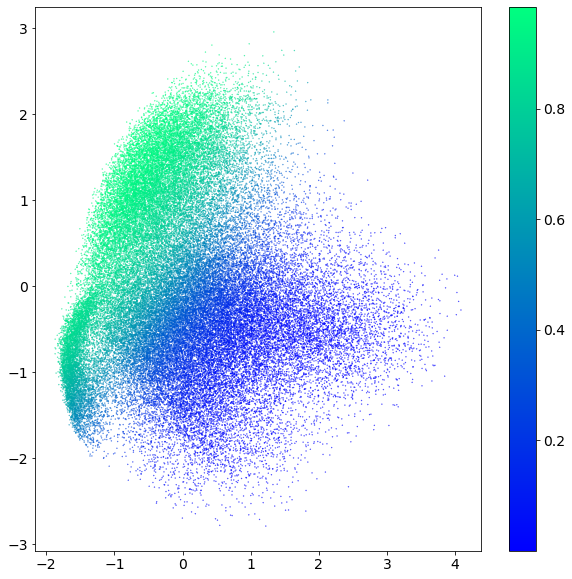

In [406]:
plt_data = plt.scatter(X_train[:, 0], X_train[:, 1], s=0.1, c=q ,cmap="winter")
plt.colorbar()

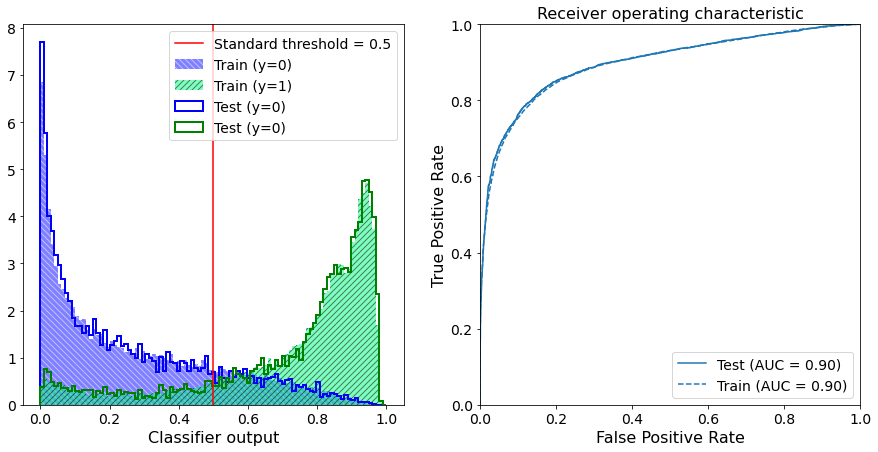

In [407]:
plot_clf(y_predicted, y_test_predicted)

## Logistic regression with gradient descent

We need to define the gradient, which means computing partial derivatives:

In [408]:
def grad(params):
    q = expit(X_train @ params[:-1] + params[-1])
    d = - (y_train * q - (1-y_train) / (1-q) * q**2) * np.exp(-(X_train @ params[:-1] + params[-1]))
    g = np.average(X_train * d[:, np.newaxis], axis=0)
    return np.concatenate((g, [np.average(d)]))
grad(params)

array([ 3.42973685e-06, -8.20345465e-06,  1.48260540e-06])

This then allows us to use a gradient descent minimizer

In [409]:
params = np.random.randn(X.shape[1] + 1)
res = optimize.minimize(loss, params, jac=grad, method="l-bfgs-b")
params = res.x

Of course it works too!

In [410]:
params

array([-1.64745853,  1.50388622, -0.14954003])

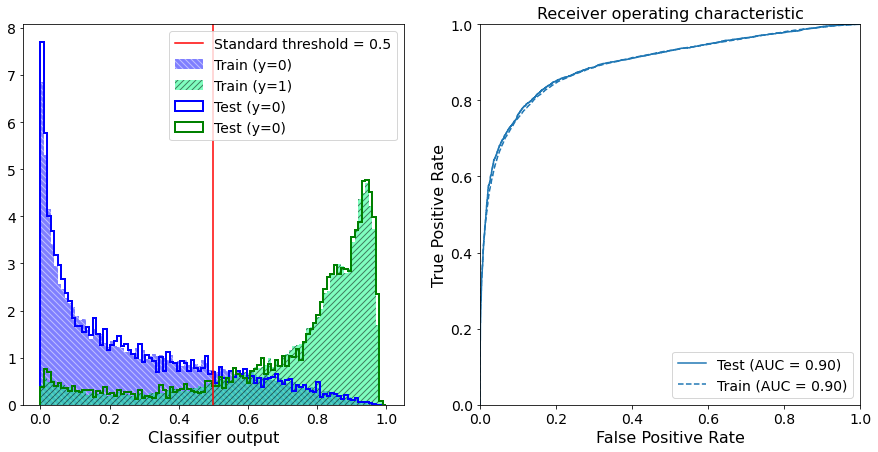

In [411]:
q = expit(X_train @ params[:-1] + params[-1])
q_test = expit(X_test @ params[:-1] + params[-1])
y_predicted = np.stack((1-q, q)).T
y_test_predicted = np.stack((1-q_test, q_test)).T
plot_clf(y_predicted, y_test_predicted)

This however gives us now the possibiliy to optimize much harder problems! We could go as far as to use as inputs the orginial vector X and optimize 785 parameters...see DL next lecture

## Auto diff

To construct the gradients automatically, we can use autodiff}

In [412]:
import tensorflow as tf

In [414]:
p = tf.Variable(params)

with tf.GradientTape() as tape:
    q = 1/(1 + tf.math.exp(-(tf.tensordot(X_train, p[:-1], axes=1) + p[-1])))
    loss = -tf.math.reduce_mean((y_train * tf.math.log(q+eps) + (1-y_train) * tf.math.log(1-q+eps)))

In [416]:
tape.gradient(loss, p).numpy()

array([ 2.88683717e-06, -1.66171003e-06, -4.60165238e-06])

And this ideed yields the same as our gradient

In [417]:
grad(params)

array([ 2.88683717e-06, -1.66171003e-06, -4.60165238e-06])

# Different classifiers from sklearn

Use a classifier, try out different ones and different settings!

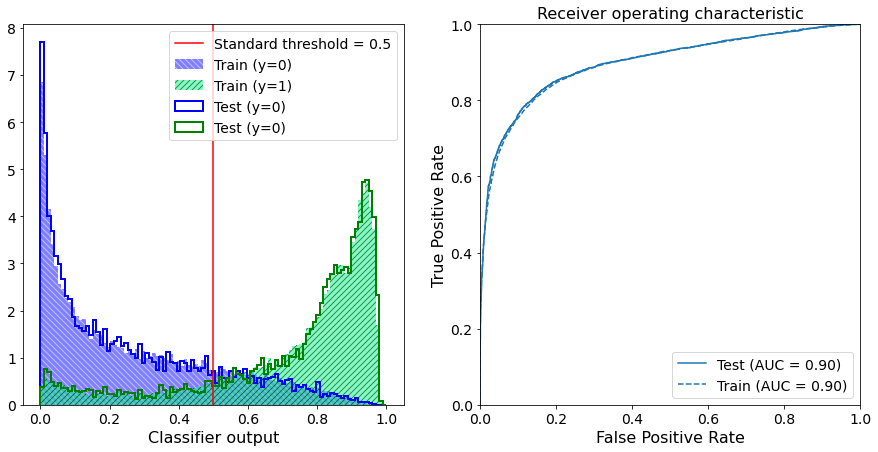

In [418]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(X_train, y_train, )
y_predicted = clf.predict_proba(X_train)
y_test_predicted = clf.predict_proba(X_test)
plot_clf(y_predicted, y_test_predicted)

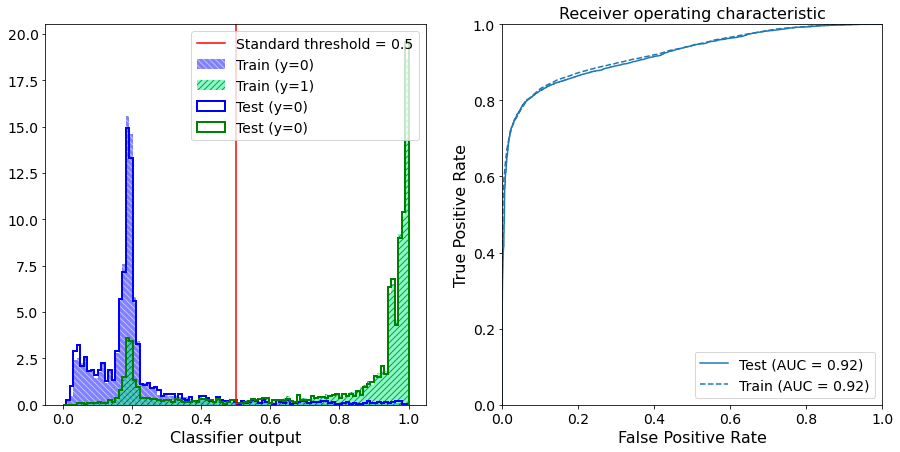

In [419]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=20, max_depth=7, criterion="entropy")
clf.fit(X_train, y_train, )
y_predicted = clf.predict_proba(X_train)
y_test_predicted = clf.predict_proba(X_test)
plot_clf(y_predicted, y_test_predicted)

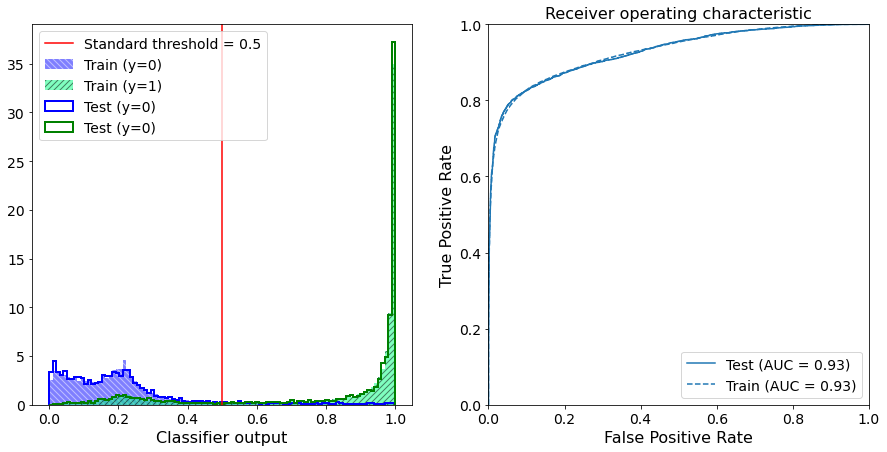

In [420]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=[64])
clf.fit(X_train, y_train, )
y_predicted = clf.predict_proba(X_train)
y_test_predicted = clf.predict_proba(X_test)
plot_clf(y_predicted, y_test_predicted)

How well is the classification doing in terms of predicting the labels? We can construct the confusion matrix:

In [421]:
from sklearn.metrics import confusion_matrix
y_predicted_label = clf.predict(X_train)
y_test_predicted_label = clf.predict(X_test)
cm = confusion_matrix(y_test, y_test_predicted_label, )

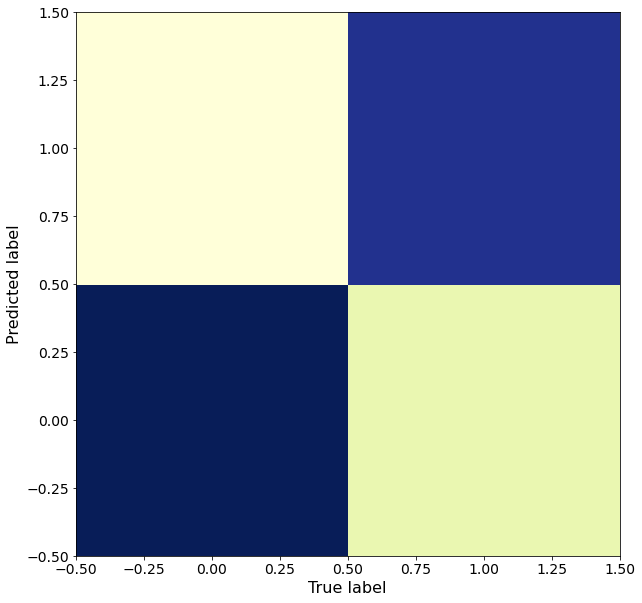

In [422]:
plt.imshow(cm.T, cmap='YlGnBu', origin='lower')
plt.gca().set_xlabel('True label')
plt.gca().set_ylabel('Predicted label')
plt.savefig('DT_confusion.png', bbox_inches='tight')

Here we plot some of the testing data that was preducted to be of class (1, 4, 5, 7, 9)

In [423]:
X_plot = X_orig[60000:]
#X_plot = X_orig[8000:]

Text(0.5, 0.98, 'Class: 1, 4, 5, 7, 9')

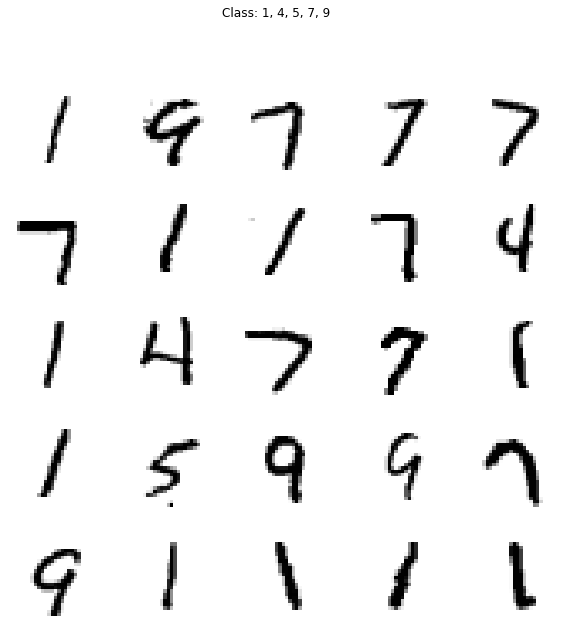

In [424]:
mask = y_test_predicted_label == 1
plot(X_plot[mask])    
plt.suptitle('Class: 1, 4, 5, 7, 9')
#plt.suptitle('Class: 0, 2, 3, 6, 8')
    
#plt.savefig('mnist.png', bbox_inches='tight')